<a href="https://colab.research.google.com/github/Priyo-prog/Time-series-analysis/blob/main/Business%20Case/volkswagen_buyout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Case : Volkswagen buyout of Porsche**

## Pip Install

In [21]:
!pip3 install numpy scipy patsy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
!pip3 install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Delete the "!pip uninstall statsmodels" once the installation is complete

## Import the Packages and Libraries

In [26]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import yfinance # yahoo finanace
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [27]:
raw_data = yfinance.download(tickers="VOW3.DE, PAH3.DE, BMW.DE", interval="1d", group_by="ticker",
                             auto_adjust=True, treads=True)

[*********************100%***********************]  3 of 3 completed


In [28]:
df = raw_data.copy()

## Defining Key Dates

In [29]:
## Starting Date
start_date = '2009-04-05'

## First Official Announcement - 49.9%
ann_1 = '2009-12-09'

## Second Official Announcement - 50.1%
ann_2 = '2012-07-05'

## Ending Date
end_date = '2014-01-01'

## Dieselgate scanndal
d_gate = '2015-09-20'

## Pre-processing the Data

In [30]:
## Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

## Creating Returns (We'll be examimng volatility)
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

## Creating Squared Returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

## Extracting Volume (Quantity extracted on that day)
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [31]:
## Assigning the frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [32]:
## Removing Surplus Data
del df['VOW3.DE'], df['PAH3.DE'], df['BMW.DE']

In [33]:
df.head()

,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,q_vol,q_por,q_bmw
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1996-11-08,32.022861,25.596836,9.333743,-4.405605,-3.831331,-0.269609,19.409359,14.679098,0.072689,56336.0,901566.0,767000.0
1996-11-11,32.022861,25.596836,9.308578,-4.405605,-3.831331,-0.269609,19.409359,14.679098,0.072689,56336.0,901566.0,260000.0
1996-11-12,32.022861,25.596836,9.378950,-4.405605,-3.831331,0.755987,19.409359,14.679098,0.571516,56336.0,901566.0,1066000.0
1996-11-13,32.022861,25.596836,9.364052,-4.405605,-3.831331,-0.158848,19.409359,14.679098,0.025233,56336.0,901566.0,793000.0
1996-11-14,32.022861,25.596836,9.394357,-4.405605,-3.831331,0.323630,19.409359,14.679098,0.104737,56336.0,901566.0,351000.0


We are not splitting the data in Training and Testing set we're examining a specific event in time, rather than trying to predict the future.

## Plotting the Prices

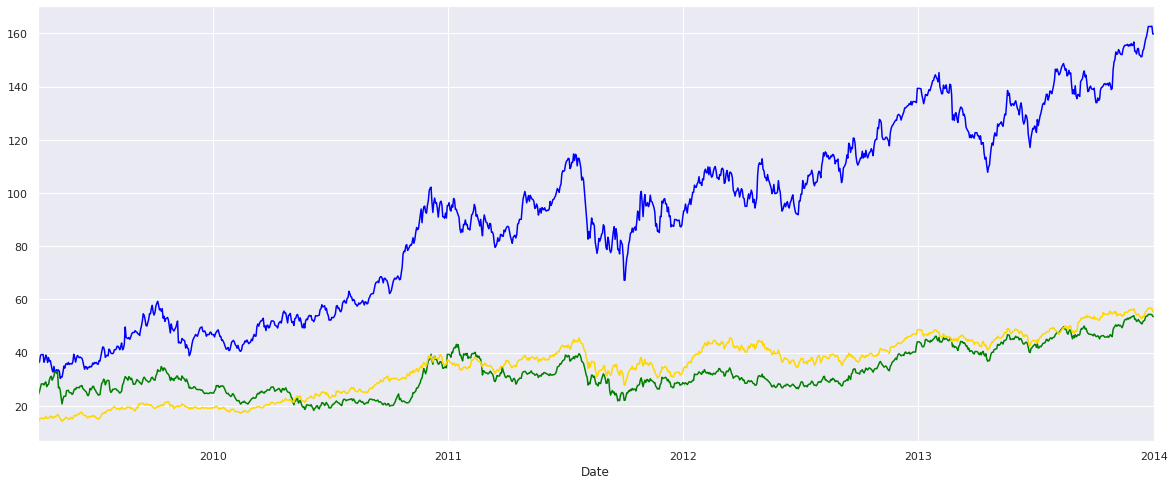

In [34]:
df['vol'][start_date:end_date].plot(figsize=(20,8), color="blue")
df['por'][start_date:end_date].plot(color="green")
df['bmw'][start_date:end_date].plot(color="gold")
plt.show()

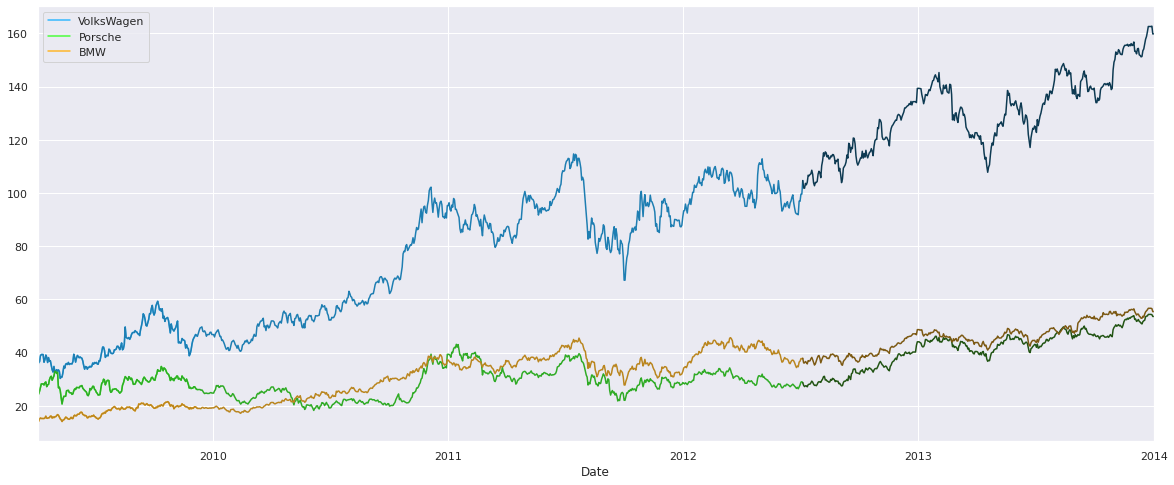

In [36]:
df['vol'][start_date:ann_1].plot(figsize=(20,8), color="#33B8FF")
df['por'][start_date:ann_1].plot(color="#49FF3A")
df['bmw'][start_date:ann_1].plot(color="#FEB628")

df['vol'][start_date:ann_2].plot(color="#1E7EB2")
df['por'][start_date:ann_2].plot(color="#2FAB25")
df['bmw'][start_date:ann_2].plot(color="#BA861F")


df['vol'][ann_2:end_date].plot(color="#0E3A52")
df['por'][ann_2:end_date].plot(color="#225414")
df['bmw'][ann_2:end_date].plot(color="#7C5913")
plt.legend(['VolksWagen', 'Porsche', 'BMW'])
plt.show()

## Correlation

In [39]:
print('Correlations among manufacturers from ' + str(start_date) + 'to' +str(end_date)+ '\n')
print('VolksWagen and Porsche correlation:\t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('VolksWagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlations among manufacturers from 2009-04-05to2014-01-01

VolksWagen and Porsche correlation:	0.8359547128707587
VolksWagen and BMW correlation: 	0.9799378242952758
Porsche and BMW correlation: 		0.8052157833891407
